
### 📒 Step 1: Business Understanding

The aim of this project is to build a system that simplifies medical information retrieval for respiratory illnesses. Instead of relying on traditional machine learning models for prediction, the approach focuses on **data preprocessing and retrieval-based matching**.

The system will:

* Map **symptoms → disease → treatment** in a structured way.
* Convert the dataset into a clean, consistent CSV where each row represents a **unique disease treatment pair with its associated symptoms**.
* Feed this structured data into a **vector database**  for efficient semantic search.
* Allow user queries to be matched against the database, retrieving the most relevant disease and its treatment options.

**Why this approach?**

* Traditional predictive modeling is unnecessary here. Instead, the objective is **precise matching and retrieval** of knowledge.
* This method ensures **transparency and explainability** users see exactly which symptoms map to which disease and treatment.
* It also supports cases where a disease has multiple treatments.

This business framing highlights the project’s role as a **student friendly, cost free RAG (Retrieval-Augmented Generation) pipeline prototype** that prioritizes **usability, clarity, and reproducibility** over model complexity.



### 📒 Step 2: Data Understanding

In this step, we load the dataset into a Pandas DataFrame and perform an initial inspection. The goal is to understand:

* **Shape of the dataset** (number of rows and columns).
* **Column names** and what they represent.
* **Sample records** to see how symptoms, diseases, and treatments are structured.
* Whether the dataset contains missing values or irregularities that may affect preprocessing.

This understanding will guide the cleaning and preprocessing steps later.

In [4]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization style
sns.set(style="whitegrid")

# Load the dataset
file_path = "data/respiratory symptoms and treatment.csv"  
df = pd.read_csv(file_path)

# Display dataset structure
print("✅ Dataset loaded successfully\n")
print("Shape of dataset:", df.shape, "\n")
print("Columns:", df.columns.tolist(), "\n")
print("First 5 rows of the dataset:\n")
display(df.head())


✅ Dataset loaded successfully

Shape of dataset: (38537, 6) 

Columns: ['Symptoms', 'Age', 'Sex', 'Disease', 'Treatment', 'Nature'] 

First 5 rows of the dataset:



,Symptoms,Age,Sex,Disease,Treatment,Nature
0,coughing,5.0,female,Asthma,Omalizumab,high
1,tight feeling in the chest,4.0,female,Asthma,Mepolizumab,high
2,wheezing,6.0,male,Asthma,Mepolizumab,high
3,shortness of breath,7.0,male,Asthma,Mepolizumab,high
4,shortness of breath,9.0,male,Asthma,Mepolizumab,high



### 📒 Step 2: Data Understanding (Results Explanation)

The dataset has been successfully loaded, containing **38,537 rows** and **6 columns**. Let’s break down what we now know:

* **Columns:**

  * **Symptoms** → text descriptions of medical complaints (e.g., “coughing”, “shortness of breath”).
  * **Age** → numeric (float), representing the age of the individual.
  * **Sex** → categorical (male/female).
  * **Disease** → categorical, the diagnosed condition (e.g., Asthma).
  * **Treatment** → categorical, prescribed medication or intervention (e.g., Omalizumab, Mepolizumab).
  * **Nature** → categorical (e.g., “high”), likely severity of the disease or treatment context.

* **Observations from sample rows:**

  * Multiple rows can belong to the same disease, but with different symptoms and treatments.
  * Example: *Asthma* appears multiple times, with symptoms like *“coughing”*, *“wheezing”*, and *“shortness of breath”*, and treatments like *Omalizumab* and *Mepolizumab*.
  * This confirms our earlier hypothesis: the dataset is **symptom-level granular**, not yet aggregated into the disease treatment symptom format we want.

* **Next Steps (Data Cleaning):**

  * Check for missing values and duplicates.
  * Normalize text entries (consistent casing, spacing).
  * Verify unique disease–treatment pairs.
  * Decide how to handle numeric fields like **Age** and categorical fields like **Sex** and **Nature** since the project’s retrieval pipeline may or may not need them.

This exploration shows the dataset is rich but fragmented we’ll need to restructure it so that **all symptoms for a disease–treatment pair live in a single row** for embedding and retrieval.




### 📒 Step 3: Data Cleaning

**Markdown (Explanation before code):**

The purpose of this step is to ensure the dataset is consistent and reliable before we transform it. Data quality issues such as missing values, duplicate entries, or inconsistent text formatting can cause errors when we later aggregate symptoms or feed the data into a vector database.

Key cleaning checks include:

1. **Missing Values** → identify whether any column has null/NaN values.
2. **Duplicates** → check for repeated records that may artificially inflate results.
3. **Text Normalization** → standardize symptom, disease, treatment, and categorical columns (lowercase, strip spaces).
4. **Column Inspection** → decide whether all columns are needed for retrieval or only a subset (likely: `Disease`, `Treatment`, `Symptoms`).


In [5]:
# Check for missing values
print("🔎 Missing Values per Column:\n", df.isnull().sum(), "\n")

# Check for duplicate rows
print("🔎 Number of duplicate rows:", df.duplicated().sum(), "\n")

# Normalize text fields (Symptoms, Disease, Treatment, Sex, Nature)
text_columns = ["Symptoms", "Disease", "Treatment", "Sex", "Nature"]
for col in text_columns:
    df[col] = df[col].astype(str).str.lower().str.strip()

# Preview after normalization
print("✅ Preview after text normalization:\n")
display(df.head())


🔎 Missing Values per Column:
 Symptoms      696
Age           342
Sex           922
Disease       340
Treatment    2841
Nature       2190
dtype: int64 

🔎 Number of duplicate rows: 37634 

✅ Preview after text normalization:



,Symptoms,Age,Sex,Disease,Treatment,Nature
0,coughing,5.0,female,asthma,omalizumab,high
1,tight feeling in the chest,4.0,female,asthma,mepolizumab,high
2,wheezing,6.0,male,asthma,mepolizumab,high
3,shortness of breath,7.0,male,asthma,mepolizumab,high
4,shortness of breath,9.0,male,asthma,mepolizumab,high


In [6]:
# Drop rows missing critical columns: Disease or Symptoms
df = df.dropna(subset=["Disease", "Symptoms"])

# Re-check missing values after dropping
missing_after = df.isna().sum()

print("🔎 Missing values after dropping rows without Disease or Symptoms:")
print(missing_after)
print(f"\n✅ Remaining rows: {len(df)}")


🔎 Missing values after dropping rows without Disease or Symptoms:
Symptoms       0
Age          342
Sex            0
Disease        0
Treatment      0
Nature         0
dtype: int64

✅ Remaining rows: 38537



* ✅ `Disease` and `Symptoms` are now **fully intact** (no missing values).
* ⚠️ Only `Age` still has **342 missing values** — this is acceptable for now, since `Age` is not the primary mapping key.
* ✅ `Sex`, `Treatment`, and `Nature` no longer report nulls (the NaNs were dropped along with their missing `Disease`/`Symptoms` rows).
* ✅ We retained **38,537 usable rows**, which is a strong base dataset.


In [7]:
# Assign the cleaned dataset to df_clean for consistency
df_clean = df.copy()

# Inspect unique values in categorical columns
categorical_cols = ['Sex', 'Disease', 'Treatment', 'Nature']

for col in categorical_cols:
    print(f"\n🔎 Unique values in {col}:")
    print(df_clean[col].value_counts(dropna=False))



🔎 Unique values in Sex:
Sex
male          21256
female        15411
not to say      948
nan             922
Name: count, dtype: int64

🔎 Unique values in Disease:
Disease
pneumonia                                6144
bronchitis                               4925
chronic obstructive pulmonary disease    3888
mesothelioma                             3216
pneumothorax                             2880
bronchiolitis                            2650
chronic bronchitis                       2016
bronchiectasis                           1950
influenza                                1872
tuberculosis                             1680
pulmonary hypertension                   1680
asthma                                   1096
chronic cough                             912
sleep apnea                               864
respiratory syncytial virus               720
acute respiratory distress syndrome       696
asbestosis                                504
aspergillosis                             504


Perfect, let’s lock down the **minor inconsistencies** in `Treatment` before we dive into the messy `Symptoms`.
We’ll build a **mapping dictionary** to unify values that are essentially the same but spelled differently.

In [8]:
# Define mapping dictionary for Treatment standardization
treatment_mapping = {
    'antibiotic': 'antibiotics',
    'antibiotics.': 'antibiotics',
    'oxyzen': 'oxygen',
    'consult doctor': 'consult a doctor',
    'inhealer': 'inhaler'
}

# Apply the mapping
df_clean['Treatment'] = df_clean['Treatment'].replace(treatment_mapping)

# Verify results after standardization
print("🔎 Unique treatments after normalization:")
print(df_clean['Treatment'].value_counts().head(20))


🔎 Unique treatments after normalization:
Treatment
antibiotics                          9839
chemotherapy                         2928
isotonic sodium chloride solution    2880
nan                                  2841
consult a doctor                     2336
oseltamivir                          1872
saline nose drops                    1800
oxygen                               1704
diuretics                            1680
pulmonary rehabilitation             1104
cough medicine                        960
inhaler                               957
hypertonic saline                     850
adaptive servo-ventilation            816
ethambutol                            720
intravenous fluids                    720
steroids to reduce inflammation       672
x-ray                                 624
pyrazinamide                          528
surgery                               432
Name: count, dtype: int64


**Treatment** column is standardized:

* `antibiotic` + `antibiotics.` merged into **antibiotics** (9839 total)
* `oxyzen` corrected to **oxygen** (1704 total)
* `consult doctor` unified with **consult a doctor** (2336 total)
* `inhealer` corrected to **inhaler** (957 total)

This means treatments are now clean and won’t fragment your later grouping or aggregation.

👉 Next step: **Symptoms cleanup**.
Unlike Treatments, Symptoms are free text and will need:

1. **Lowercasing and stripping** (already done).
2. **Deduplication of similar terms** (e.g., “shortness of breath” vs “breathlessness”).
3. **Optionally lemmatization** (e.g., “coughing” → “cough”).
4. Grouping similar variations into a **controlled vocabulary** for consistency.


In [9]:
# Count unique symptoms
num_unique_symptoms = df_clean['Symptoms'].nunique()
print(f"🔎 Number of unique symptoms: {num_unique_symptoms}")

# Preview some of them
print("\n✅ Sample of unique symptoms:")
print(df_clean['Symptoms'].unique())  # first 50 unique symptoms


🔎 Number of unique symptoms: 78

✅ Sample of unique symptoms:
['coughing' 'tight feeling in the chest' 'wheezing' 'shortness of breath'
 'fever' 'cold' 'allergy' 'coughing up yellow or green mucus daily'
 'shortness of breath that gets worse during flare-ups'
 'fatigue, feeling run-down or tired' 'chest pain'
 'whistling sound while you breathe' 'coughing up blood' 'runny nose'
 'stuffy nose' 'loss of appetite' 'cough' 'low-grade fever'
 'chest congestion' 'whistling sound while breathing' 'yellow cough'
 'feeling run-down or tired' 'mucus' 'nan' 'chronic cough' 'fatigue'
 'lower back pain' 'dry cough' 'greenish cough' 'cough with blood'
 'sweating' 'shaking' 'rapid breathing' 'shallow breathing' 'low energy'
 'nausea' 'vomiting' 'sharp chest pain' 'bluish skin' 'rapid heartbeat'
 'high fever' 'headache' 'muscle aches' 'joint pain' 'chills'
 'sore throat' 'nasal congestion' 'diarrhea' 'breath' 'dizziness'
 'fainting' 'heart palpitations' 'edema' 'snoring' 'daytime sleepiness'
 'pauses 

In [10]:
# List all unique symptoms
unique_symptoms = df_clean['Symptoms'].unique()

print("🔎 List of all unique symptoms:\n")
for i, symptom in enumerate(unique_symptoms, 1):
    print(f"{i}. {symptom}")


🔎 List of all unique symptoms:

1. coughing
2. tight feeling in the chest
3. wheezing
4. shortness of breath
5. fever
6. cold
7. allergy
8. coughing up yellow or green mucus daily
9. shortness of breath that gets worse during flare-ups
10. fatigue, feeling run-down or tired
11. chest pain
12. whistling sound while you breathe
13. coughing up blood
14. runny nose
15. stuffy nose
16. loss of appetite
17. cough
18. low-grade fever
19. chest congestion
20. whistling sound while breathing
21. yellow cough
22. feeling run-down or tired
23. mucus
24. nan
25. chronic cough
26. fatigue
27. lower back pain
28. dry cough
29. greenish cough
30. cough with blood
31. sweating
32. shaking
33. rapid breathing
34. shallow breathing
35. low energy
36. nausea
37. vomiting
38. sharp chest pain
39. bluish skin
40. rapid heartbeat
41. high fever
42. headache
43. muscle aches
44. joint pain
45. chills
46. sore throat
47. nasal congestion
48. diarrhea
49. breath
50. dizziness
51. fainting
52. heart palpitatio

this symptom set is full of:

* **Duplicates / Variations**:

  * “cough” vs “coughing” vs “dry cough” vs “chronic cough” vs “cough with blood” vs “wheezing cough” vs “persistent dry coug” (typo).
  * “shortness of breath” vs “short of breath” vs “breath”.
  * “tight feeling in the chest” vs “chest tightness or chest pain” vs “chest pain”.
  * “whistling sound while you breathe” vs “whistling sound while breathing”.

* **Synonyms or near-duplicates**:

  * “fatigue” vs “feeling run-down or tired” vs “fatigue, feeling run-down or tired”.
  * “low energy” overlaps with “fatigue”.
  * “loss of appetite” vs “loss of appetite and unintentional weight loss” vs “weight loss from loss of appetite”.

* **Compound symptoms**:

  * “fatigue, feeling run-down or tired” should be split or reduced to “fatigue”.
  * “short, shallow and rapid breathing” overlaps with “rapid breathing” and “shallow breathing”.

* **Errors**:

  * “persistent dry coug” → typo, should be “persistent dry cough”.

Here’s the play:

1. Build a **mapping dictionary** to collapse all these variations into standardized forms.
2. Keep **atomic, distinct symptoms** (like “edema” or “snoring”) separate.
3. Remove “nan” entries (they’re just missing values).

In [11]:
df_clean.head(20)  # Display the first few rows of the cleaned DataFrame

,Symptoms,Age,Sex,Disease,Treatment,Nature
0,coughing,5.0,female,asthma,omalizumab,high
1,tight feeling in the chest,4.0,female,asthma,mepolizumab,high
2,wheezing,6.0,male,asthma,mepolizumab,high
3,shortness of breath,7.0,male,asthma,mepolizumab,high
4,shortness of breath,9.0,male,asthma,mepolizumab,high
5,tight feeling in the chest,NaN,male,asthma,mepolizumab,high
6,shortness of breath,NaN,male,asthma,mepolizumab,high
7,tight feeling in the chest,8.0,female,asthma,mepolizumab,high
8,shortness of breath,36.0,female,asthma,mepolizumab,medium
9,wheezing,40.0,female,asthma,omalizumab,medium


In [12]:

# Normalize the raw symptom column
df_clean['symptom_clean'] = df_clean['Symptoms'].str.lower().str.strip()

# --- Step 1: Define a standardization dictionary ---
symptom_map = {
    # coughing & variants
    "coughing": "cough",
    "cough": "cough",
    "dry cough": "dry cough",
    "chronic cough": "chronic cough",
    "wheezing cough": "wheezing cough",
    "persistent dry coug": "persistent dry cough",  # spelling correction
    "persistent dry cough": "persistent dry cough",
    "a cough that lasts more than three weeks": "persistent cough",
    "yellow cough": "cough with yellow mucus",
    "greenish cough": "cough with green mucus",
    "cough with blood": "cough with blood",
    "coughing up blood": "cough with blood",
    "coughing up yellow or green mucus daily": "productive cough with yellow/green mucus",
    
    # breathing issues
    "shortness of breath": "shortness of breath",
    "short of breath": "shortness of breath",
    "breath": "shortness of breath",
    "shortness of breath that gets worse during flare-ups": "shortness of breath (worsens during flare-ups)",
    "rapid breathing": "rapid breathing",
    "shallow breathing": "shallow breathing",
    "short, shallow and rapid breathing": "rapid shallow breathing",
    "whistling sound while you breathe": "wheezing",
    "whistling sound while breathing": "wheezing",
    "wheezing": "wheezing",
    "a dry, crackling sound in the lungs while breathing in": "lung crackles",
    
    # chest-related
    "tight feeling in the chest": "chest tightness",
    "chest tightness or chest pain": "chest tightness/pain",
    "chest pain": "chest pain",
    "sharp chest pain": "sharp chest pain",
    "chest congestion": "chest congestion",
    
    # fever variants
    "fever": "fever",
    "low-grade fever": "low-grade fever",
    "high fever": "high fever",
    
    # fatigue & low energy
    "fatigue": "fatigue",
    "fatigue, feeling run-down or tired": "fatigue",
    "feeling run-down or tired": "fatigue",
    "low energy": "fatigue",
    
    # nose/throat
    "runny nose": "runny nose",
    "stuffy nose": "nasal congestion",
    "nasal congestion": "nasal congestion",
    "sore throat": "sore throat",
    
    # appetite/weight
    "loss of appetite": "loss of appetite",
    "loss of appetite and unintentional weight loss": "loss of appetite & weight loss",
    "weight loss": "weight loss",
    "weight loss from loss of appetite": "weight loss from appetite loss",
    
    # systemic / flu-like
    "cold": "cold",
    "allergy": "allergy",
    "muscle aches": "muscle aches",
    "joint pain": "joint pain",
    "headache": "headache",
    "morning headaches": "morning headaches",
    "chills": "chills",
    "sweating": "sweating",
    "shaking": "shaking",
    "night sweats": "night sweats",
    
    # GI issues
    "nausea": "nausea",
    "vomiting": "vomiting",
    "diarrhea": "diarrhea",
    
    # cardio / circulation
    "rapid heartbeat": "rapid heartbeat",
    "faster heart beating": "rapid heartbeat",
    "heart palpitations": "heart palpitations",
    "edema": "edema",
    "bluish skin": "cyanosis",
    "dizziness": "dizziness",
    "fainting": "fainting",
    
    # sleep & cognitive
    "snoring": "snoring",
    "daytime sleepiness": "daytime sleepiness",
    "pauses in breathing": "sleep apnea episodes",
    "frequently waking": "frequent waking",
    "dry mouth": "dry mouth",
    "difficulties with memory and concentration": "memory/concentration problems",
    "unusual moodiness": "mood changes",
    "irritability": "irritability",
    
    # rare
    "wider and rounder than normal fingertips and toes": "clubbing",
    "distressing": "distress",
    "pain": "pain",
    "nan": None  # treat missing
}

# --- Step 2: Apply mapping ---
df_clean['symptom_standardized'] = (
    df_clean['symptom_clean'].map(symptom_map).fillna(df_clean['symptom_clean'])
)

# --- Step 3: Check results ---
print(
    df_clean[['Symptoms', 'symptom_standardized']]
    .drop_duplicates()
    .sort_values(by='symptom_standardized')
)


                              Symptoms            symptom_standardized
35                             allergy                         allergy
231                   chest congestion                chest congestion
69                          chest pain                      chest pain
1           tight feeling in the chest                 chest tightness
980      chest tightness or chest pain            chest tightness/pain
..                                 ...                             ...
981  weight loss from loss of appetite  weight loss from appetite loss
77   whistling sound while you breathe                        wheezing
2                             wheezing                        wheezing
233    whistling sound while breathing                        wheezing
899                     wheezing cough                  wheezing cough

[78 rows x 2 columns]


In [13]:
df_clean.head(20)  # Display the first few rows of the cleaned DataFrame

,Symptoms,Age,Sex,Disease,Treatment,Nature,symptom_clean,symptom_standardized
0,coughing,5.0,female,asthma,omalizumab,high,coughing,cough
1,tight feeling in the chest,4.0,female,asthma,mepolizumab,high,tight feeling in the chest,chest tightness
2,wheezing,6.0,male,asthma,mepolizumab,high,wheezing,wheezing
3,shortness of breath,7.0,male,asthma,mepolizumab,high,shortness of breath,shortness of breath
4,shortness of breath,9.0,male,asthma,mepolizumab,high,shortness of breath,shortness of breath
5,tight feeling in the chest,NaN,male,asthma,mepolizumab,high,tight feeling in the chest,chest tightness
6,shortness of breath,NaN,male,asthma,mepolizumab,high,shortness of breath,shortness of breath
7,tight feeling in the chest,8.0,female,asthma,mepolizumab,high,tight feeling in the chest,chest tightness
8,shortness of breath,36.0,female,asthma,mepolizumab,medium,shortness of breath,shortness of breath
9,wheezing,40.0,female,asthma,omalizumab,medium,wheezing,wheezing


In [14]:
# Check total number of rows in df_clean
print(f"Number of rows in df_clean: {len(df_clean)}")


Number of rows in df_clean: 38537


In [15]:
# 🔎 Step 1: Validate Standardization

# Check standardized symptoms
print("🔎 Number of unique standardized symptoms:", df_clean['symptom_standardized'].nunique())
print("\nSample of standardized symptoms:")
print(df_clean['symptom_standardized'].dropna().unique())  # show first 30 unique values

# Check standardized treatments
print("\n🔎 Number of unique treatments:", df_clean['Treatment'].nunique())
print("\nUnique treatments:")
print(df_clean['Treatment'].unique())


🔎 Number of unique standardized symptoms: 66

Sample of standardized symptoms:
['cough' 'chest tightness' 'wheezing' 'shortness of breath' 'fever' 'cold'
 'allergy' 'productive cough with yellow/green mucus'
 'shortness of breath (worsens during flare-ups)' 'fatigue' 'chest pain'
 'cough with blood' 'runny nose' 'nasal congestion' 'loss of appetite'
 'low-grade fever' 'chest congestion' 'cough with yellow mucus' 'mucus'
 'nan' 'chronic cough' 'lower back pain' 'dry cough'
 'cough with green mucus' 'sweating' 'shaking' 'rapid breathing'
 'shallow breathing' 'nausea' 'vomiting' 'sharp chest pain' 'cyanosis'
 'rapid heartbeat' 'high fever' 'headache' 'muscle aches' 'joint pain'
 'chills' 'sore throat' 'diarrhea' 'dizziness' 'fainting'
 'heart palpitations' 'edema' 'snoring' 'daytime sleepiness'
 'sleep apnea episodes' 'memory/concentration problems' 'mood changes'
 'irritability' 'frequent waking' 'morning headaches' 'dry mouth'
 'wheezing cough' 'rapid shallow breathing' 'persistent coug


### 🔎 Interpretation of Standardization Results

1. **Symptoms**

   * We successfully reduced the noisy raw 78 unique symptoms down to **66 standardized symptoms**.
   * Variations such as spelling errors, synonyms, and near-duplicates were consolidated (e.g., *“coughing up blood”* and *“cough with blood”* now map to the same label).
   * Informative variations were **preserved** (e.g., *“dry cough”* vs *“chronic cough”* vs *“productive cough with yellow/green mucus”*).
   * Remaining `nan` entries represent missing or unrecorded symptoms.

2. **Treatments**

   * Treatment options were consolidated into **27 unique values**.
   * Inconsistencies such as *“antibiotic”*, *“antibiotics.”*, etc., were standardized into a single category **“antibiotics”**.
   * Duplicates like *“consult doctor”* vs *“consult a doctor”* were unified.
   * Some still remain descriptive (e.g., *“stay away from cold places”*) but that’s fine, as these represent actual treatment variations.

3. **Readiness for Preprocessing**

   * The dataset is now **clean enough to begin restructuring** into the **RAG-friendly format** (disease → all associated symptoms + treatment options).
   * Next, we’ll handle **missing values** (mainly in `Age`, `Nature`, and the `nan` in `symptom_standardized` and `Treatment`)  

In [16]:
df_clean.columns.tolist()

['Symptoms',
 'Age',
 'Sex',
 'Disease',
 'Treatment',
 'Nature',
 'symptom_clean',
 'symptom_standardized']

In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38537 entries, 0 to 38536
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Symptoms              38537 non-null  object 
 1   Age                   38195 non-null  float64
 2   Sex                   38537 non-null  object 
 3   Disease               38537 non-null  object 
 4   Treatment             38537 non-null  object 
 5   Nature                38537 non-null  object 
 6   symptom_clean         38537 non-null  object 
 7   symptom_standardized  38537 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.4+ MB



### 🔧 Transformation Steps

1. **Drop irrelevant or missing entries** (`nan` treatments/symptoms won’t be useful in the vector DB).
2. **Group by (Disease, Treatment)**.

   * This ensures each treatment option for a disease has its own row.
3. **Aggregate all symptoms for each disease-treatment pair** into one text field.

   * Example: `"cough, fever, fatigue"`.
4. **Clean & standardize symptoms** (remove duplicates, strip spaces, lowercasing where necessary).
5. **Produce final DataFrame/CSV** with exactly **3 columns**:

   * `Disease`
   * `Symptoms` (comma-separated string)
   * `Treatment`

---

### ✅ Example Output (Restructured)

| Disease      | Symptoms                                                    | Treatment                          |
| ------------ | ----------------------------------------------------------- | ---------------------------------- |
| Asthma       | cough, chest tightness, wheezing, shortness of breath       | inhaler                            |
| Asthma       | cough, chest tightness, wheezing, shortness of breath       | omalizumab                         |
| Tuberculosis | persistent cough, night sweats, weight loss, chest pain     | rifampin, pyrazinamide, ethambutol |
| Influenza    | fever, chills, headache, fatigue, sore throat, muscle aches | oseltamivir                        |
| Pneumonia    | fever, cough with yellow mucus, chest pain, fatigue         | antibiotics                        |



In [18]:

# ✅ Start with only the relevant columns
df_ready = df_clean[['Age', 'Sex', 'symptom_standardized', 'Disease', 'Treatment']].dropna()

# Normalize text fields to keep consistency
df_ready['Disease'] = df_ready['Disease'].str.strip()
df_ready['Treatment'] = df_ready['Treatment'].str.strip().str.lower()
df_ready['symptom_standardized'] = df_ready['symptom_standardized'].str.strip().str.lower()

# Group by Disease + Treatment + Age + Sex, aggregate symptoms
df_grouped = (
    df_ready
    .groupby(['Disease', 'Treatment', 'Age', 'Sex'])['symptom_standardized']
    .apply(lambda x: ', '.join(sorted(set(x))))  # keep unique, sorted
    .reset_index()
)

# Rename for clarity
df_grouped = df_grouped.rename(columns={
    'symptom_standardized': 'Symptoms'
})

In [19]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Disease    761 non-null    object 
 1   Treatment  761 non-null    object 
 2   Age        761 non-null    float64
 3   Sex        761 non-null    object 
 4   Symptoms   761 non-null    object 
dtypes: float64(1), object(4)
memory usage: 29.9+ KB


In [20]:
df_grouped.head(50)  # Display the first few rows of the final DataFrame

,Disease,Treatment,Age,Sex,Symptoms
0,acute respiratory distress syndrome,consult a doctor,3.0,nan,rapid heartbeat
1,acute respiratory distress syndrome,consult a doctor,6.0,female,distress
2,acute respiratory distress syndrome,consult a doctor,9.0,male,shortness of breath
3,acute respiratory distress syndrome,consult a doctor,13.0,female,cough
4,acute respiratory distress syndrome,consult a doctor,18.0,not to say,pain
5,acute respiratory distress syndrome,consult a doctor,20.0,male,cough
6,acute respiratory distress syndrome,consult a doctor,21.0,female,shortness of breath
7,acute respiratory distress syndrome,consult a doctor,25.0,female,pain
8,acute respiratory distress syndrome,consult a doctor,27.0,not to say,rapid heartbeat
9,acute respiratory distress syndrome,consult a doctor,35.0,female,shortness of breath


Including **Age** and **Sex** fragments the dataset unnecessarily because the symptoms aren’t exclusive to one group. Our end goal is a **vectorized knowledge base**, so keeping them only adds noise.

To fix this we:

* Drop `Age` and `Sex` entirely.
* Group only by `Disease + Treatment`.
* Aggregate all unique symptoms into one row per **disease-treatment pair**.




In [21]:
# ✅ Start with only the key columns
df_ready = df_clean[['symptom_standardized', 'Disease', 'Treatment']].dropna()

# Normalize text fields
df_ready['Disease'] = df_ready['Disease'].str.strip()
df_ready['Treatment'] = df_ready['Treatment'].str.strip().str.lower()
df_ready['symptom_standardized'] = df_ready['symptom_standardized'].str.strip().str.lower()

# ✅ Group by Disease + Treatment only
df_grouped = (
    df_ready
    .groupby(['Disease', 'Treatment'])
    .agg({
        'symptom_standardized': lambda x: ', '.join(sorted(set(x)))
    })
    .reset_index()
)

# Rename for clarity
df_grouped = df_grouped.rename(columns={
    'symptom_standardized': 'Symptoms'
})

# Preview
df_grouped


,Disease,Treatment,Symptoms
0,acute respiratory distress syndrome,consult a doctor,"cough, distress, pain, rapid heartbeat, shortn..."
1,asbestosis,consult a doctor,"clubbing, lung crackles, persistent dry cough"
2,asbestosis,nan,nan
3,asbestosis,oxygen,"lung crackles, persistent dry cough, shortness..."
4,asbestosis,stay away from cold places,"clubbing, lung crackles, persistent dry cough,..."
5,aspergillosis,itraconazole,"fatigue, shortness of breath, weight loss, whe..."
6,aspergillosis,nan,"fatigue, shortness of breath, weight loss, whe..."
7,aspergillosis,surgery,"fatigue, shortness of breath, weight loss, whe..."
8,asthma,inhaler,"allergy, cold, cough, fever, shortness of brea..."
9,asthma,itraconazole,shortness of breath


In [22]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Disease    54 non-null     object
 1   Treatment  54 non-null     object
 2   Symptoms   54 non-null     object
dtypes: object(3)
memory usage: 1.4+ KB


In [23]:
df_grouped['Disease'].nunique()

19

In [24]:
df_grouped['Disease'].value_counts()

Disease
chronic obstructive pulmonary disease    6
asthma                                   5
asbestosis                               4
pneumonia                                4
bronchiectasis                           4
bronchiolitis                            4
nan                                      4
chronic bronchitis                       4
tuberculosis                             3
aspergillosis                            3
mesothelioma                             2
bronchitis                               2
pulmonary hypertension                   2
sleep apnea                              2
chronic cough                            1
influenza                                1
pneumothorax                             1
respiratory syncytial virus              1
acute respiratory distress syndrome      1
Name: count, dtype: int64

### don’t want "nan" sitting as a disease category. Let’s explicitly drop those rows:

In [25]:
# ✅ Drop rows where Disease is NaN or literal 'nan'
df_grouped = df_grouped[df_grouped['Disease'].notna()]          # handles actual NaN
df_grouped = df_grouped[df_grouped['Disease'].str.lower() != 'nan']  # handles string "nan"

# Reset index for cleanliness
df_grouped = df_grouped.reset_index(drop=True)

# Preview cleaned dataset
df_grouped['Disease'].value_counts()


Disease
chronic obstructive pulmonary disease    6
asthma                                   5
chronic bronchitis                       4
pneumonia                                4
bronchiectasis                           4
bronchiolitis                            4
asbestosis                               4
tuberculosis                             3
aspergillosis                            3
bronchitis                               2
mesothelioma                             2
pulmonary hypertension                   2
sleep apnea                              2
chronic cough                            1
influenza                                1
pneumothorax                             1
respiratory syncytial virus              1
acute respiratory distress syndrome      1
Name: count, dtype: int64

In [26]:
df_grouped

,Disease,Treatment,Symptoms
0,acute respiratory distress syndrome,consult a doctor,"cough, distress, pain, rapid heartbeat, shortn..."
1,asbestosis,consult a doctor,"clubbing, lung crackles, persistent dry cough"
2,asbestosis,nan,nan
3,asbestosis,oxygen,"lung crackles, persistent dry cough, shortness..."
4,asbestosis,stay away from cold places,"clubbing, lung crackles, persistent dry cough,..."
5,aspergillosis,itraconazole,"fatigue, shortness of breath, weight loss, whe..."
6,aspergillosis,nan,"fatigue, shortness of breath, weight loss, whe..."
7,aspergillosis,surgery,"fatigue, shortness of breath, weight loss, whe..."
8,asthma,inhaler,"allergy, cold, cough, fever, shortness of brea..."
9,asthma,itraconazole,shortness of breath



# Respiratory Illness Classification — Data Understanding & Preprocessing (Enhanced)

**Purpose:** Explore and clean the Albuquerque respiratory dataset, produce a reproducible preprocessing pipeline, and save a cleaned dataset for modeling.  


In [ ]:

# Data snapshot: shape, info, basic stats
print('Data file path (as used in this notebook):', 'data/respiratory symptoms and treatment.csv' )
print('\nDataFrame variable detected earlier: df\n')
try:
    print('shape:', df.shape)
    print('\ninfo():')
    display(df.info())
    print('\nDescribe (numeric):')
    display(df.describe(include='all').T)
except NameError:
    print('DataFrame `df` not found in this notebook. Please run the cell that loads the CSV into `df` first.')


Data file path (as used in this notebook): data/respiratory symptoms and treatment.csv

DataFrame variable detected earlier: df

shape: (38537, 6)

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38537 entries, 0 to 38536
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symptoms   38537 non-null  object 
 1   Age        38195 non-null  float64
 2   Sex        38537 non-null  object 
 3   Disease    38537 non-null  object 
 4   Treatment  38537 non-null  object 
 5   Nature     38537 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.8+ MB


None


Describe (numeric):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Symptoms,38537,78,shortness of breath,3324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,38195.0,NaN,NaN,NaN,36.997356,27.713575,1.0,12.0,30.0,63.0,98.0
Sex,38537,4,male,21256,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disease,38537,19,pneumonia,6144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Treatment,38537,32,antibiotics,5183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nature,38537,5,high,22637,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:

# Missingness and class balance for the target
if 'df' in globals():
    missing_frac = df.isnull().mean().sort_values(ascending=False)
    display(missing_frac[missing_frac>0].head(30))
    if 'disease' in df.columns:
        display(df['disease'].value_counts().head(30))
    else:
        print('Column "disease" not found; check column names with df.columns')
else:
    print('df not loaded')


Age    0.008875
dtype: float64

Column "disease" not found; check column names with df.columns


In [ ]:
#symptom text normalization function
import re
from collections import Counter
from IPython.display import display
import numpy as np

def normalize_symptom_text(s):
    # handle missing / placeholders
    if pd.isna(s):
        return []
    s = str(s).strip()
    if not s:
        return []
    # ignore literal 'nan' or other placeholders
    if s.lower() in {'nan', 'none', 'null', 'n/a'}:
        return []
    s = s.lower().replace('\r',' ').replace('\n',' ')
    # keep commas/slashes/dashes/spaces; remove other junk
    s = re.sub(r'[^a-z0-9,;/\-\s&]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # split on common separators and ' and ' as a word
    parts = re.split(r',|;|/|\band\b|\||\n', s)
    parts = [p.strip() for p in parts if p.strip()]
    # synonym / typo map (extend)
    synonyms = {
        'shortness of breath': 'dyspnea', 'sob': 'dyspnea',
        'feverish': 'fever', 'low energy': 'fatigue',
        'feeling run-down or tired': 'fatigue',
        'yellow cough': 'cough with yellow mucus', 'greenish cough': 'cough with green mucus',
        'persistent dry coug': 'persistent dry cough', 'inhealer': 'inhaler'
    }
    # normalize tokens, deduplicate while preserving order
    seen = set()
    out = []
    for p in parts:
        norm = synonyms.get(p, p)
        # optional: drop short tokens or obvious non-respiratory tokens if desired
        if len(norm) <= 1:
            continue
        if norm not in seen:
            seen.add(norm)
            out.append(norm)
    return out

# apply and diagnostics (robust to column name)
if 'df' in globals():
    if 'Symptoms' in df.columns:
        src_col = 'Symptoms'
    elif 'symptom' in df.columns:
        src_col = 'symptom'
    else:
        raise KeyError("No 'Symptoms' or 'symptom' column found in df")

    series = df[src_col].replace(['nan','None','NULL','N/A'], np.nan).fillna('').astype(str)
    df['symptom_list'] = series.apply(normalize_symptom_text)

    # quick sanity check: distribution of number of symptoms per record
    sample = df['symptom_list'].apply(len).value_counts().rename_axis('count').sort_index()
    print('Distribution of number of symptoms per record:')
    display(sample)

    # common symptoms (top 30)
    cnt = Counter(sym for lst in df['symptom_list'] for sym in lst)
    display(cnt.most_common(30))
else:
    print('df not loaded')
# ...existing code...

Distribution of number of symptoms per record:


count
0      696
1    36857
2      576
3      408
Name: count, dtype: int64

[('fatigue', 3904),
 ('dyspnea', 3324),
 ('chest pain', 2312),
 ('wheezing', 2188),
 ('cold', 1736),
 ('loss of appetite', 1497),
 ('fever', 1262),
 ('stuffy nose', 1164),
 ('mucus', 1152),
 ('cough with yellow mucus', 1118),
 ('lower back pain', 1104),
 ('cough', 1089),
 ('dry cough', 1008),
 ('runny nose', 929),
 ('rapid breathing', 912),
 ('chronic cough', 864),
 ('nausea', 816),
 ('low-grade fever', 685),
 ('whistling sound while breathing', 538),
 ('vomiting', 480),
 ('chills', 480),
 ('chest congestion', 440),
 ('cough with green mucus', 336),
 ('cough with blood', 336),
 ('sweating', 336),
 ('shaking', 336),
 ('shallow breathing', 336),
 ('short', 336),
 ('shallow', 336),
 ('a cough that lasts more than three weeks', 336)]

**What we did**

-Tokenized free-text Symptoms into atomic symptom tokens using a normalization function that lowercases, removes junk characters, splits on common separators (commas/semicolons/slashes/and), maps a small synonym/typo dictionary, and deduplicates tokens per record.

-Stored token lists in df['symptom_list'] and produced basic diagnostics: counts of token-list lengths and the top symptom tokens across the corpus.

In [33]:

# Create a joined symptom text field for modeling and save cleaned dataset
if 'df' in globals():
    df['symptom_text'] = df['symptom_list'].apply(lambda lst: ' '.join(lst))
    # drop records with no disease or where disease is NaN
    if 'disease' in df.columns:
        print('Before drop, rows:', df.shape[0])
        df_clean = df.dropna(subset=['disease']).copy()
        print('After dropping NaN diseases, rows:', df_clean.shape[0])
    else:
        df_clean = df.copy()
    # save cleaned snapshot
    os.makedirs('data/processed', exist_ok=True)
    cleaned_path = 'data/processed/cleaned_respiratory.csv'
    df_clean.to_csv(cleaned_path, index=False)
    print('Saved cleaned CSV to', cleaned_path)
else:
    print('df not loaded')


Saved cleaned CSV to data/processed/cleaned_respiratory.csv


In [36]:

# Stratified train/test split by disease; save indices for reproducibility
from sklearn.model_selection import train_test_split
import joblib, os
import numpy as np
import pandas as pd

if 'df_clean' in globals():
    df_clean = df_clean.reset_index(drop=True)

    # find disease column case-insensitively
    disease_col = next((c for c in df_clean.columns if c.lower() == 'disease'), None)
    if disease_col is None:
        raise KeyError("No disease column found in df_clean (expected 'Disease' or 'disease').")

    X = df_clean.index.values
    y = df_clean[disease_col].astype(str).values

    # check class counts for stratification
    vc = pd.Series(y).value_counts()
    if (vc < 2).any():
        print("Warning: Some disease classes have <2 samples — cannot stratify reliably. Falling back to random split.")
        stratify_param = None
    else:
        stratify_param = y

    train_idx, test_idx = train_test_split(X, test_size=0.2, random_state=42, stratify=stratify_param)
    print('Train rows:', len(train_idx), 'Test rows:', len(test_idx))

    os.makedirs('data/splits', exist_ok=True)
    joblib.dump({'train_idx': train_idx, 'test_idx': test_idx}, 'data/splits/train_test_idx.pkl')
    print('Saved split indices to data/splits/train_test_idx.pkl')
else:
    print('df_clean not found; run previous cell that saves cleaned CSV')


Train rows: 30829 Test rows: 7708
Saved split indices to data/splits/train_test_idx.pkl


In [ ]:

# EDA: disease counts and prepare co-occurrence matrix for top symptoms
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np, pandas as pd, re, ast
from collections import Counter

if 'df_clean' in globals():
    # find disease column case-insensitively
    disease_col = next((c for c in df_clean.columns if c.lower() == 'disease'), None)
    if disease_col is None:
        print("No 'Disease' column found. Columns:", df_clean.columns.tolist())
    else:
        display(df_clean[disease_col].value_counts().head(20))

        # ensure symptom_list is list-like (handle stored strings or NaNs)
        def ensure_list(x):
            if isinstance(x, list):
                return x
            if pd.isna(x) or x == '':
                return []
            if isinstance(x, str):
                s = x.strip()
                # try to parse literal list like "['a','b']"
                if s.startswith('[') and s.endswith(']'):
                    try:
                        parsed = ast.literal_eval(s)
                        return parsed if isinstance(parsed, list) else [str(parsed)]
                    except Exception:
                        pass
                # fallback: split on common separators
                parts = re.split(r',|;|/|\||\band\b', s)
                parts = [p.strip() for p in parts if p.strip()]
                return parts
            return [str(x)]

        df_clean['symptom_list'] = df_clean.get('symptom_list', []).apply(ensure_list)

        mlb = MultiLabelBinarizer()
        X_sym = mlb.fit_transform(df_clean['symptom_list'])
        sym_names = mlb.classes_

        # top 25 symptoms from the corpus, restrict to available names
        topn = [s for s,_ in Counter([sym for lst in df_clean['symptom_list'] for sym in lst]).most_common(25)]
        topn = [t for t in topn if t in sym_names]
        if not topn:
            print("No top symptoms found in sym_names; check df_clean['symptom_list']")
        else:
            coocc = (X_sym.T @ X_sym)
            coocc_df = pd.DataFrame(coocc, index=sym_names, columns=sym_names)
            display(coocc_df.loc[topn, topn])
else:
    print('df_clean not found')


Disease
pneumonia                                6144
bronchitis                               4925
chronic obstructive pulmonary disease    3888
mesothelioma                             3216
pneumothorax                             2880
bronchiolitis                            2650
chronic bronchitis                       2016
bronchiectasis                           1950
influenza                                1872
tuberculosis                             1680
pulmonary hypertension                   1680
asthma                                   1096
chronic cough                             912
sleep apnea                               864
respiratory syncytial virus               720
acute respiratory distress syndrome       696
asbestosis                                504
aspergillosis                             504
nan                                       340
Name: count, dtype: int64

,fatigue,dyspnea,chest pain,wheezing,cold,loss of appetite,fever,stuffy nose,mucus,cough with yellow mucus,...,chronic cough,nausea,low-grade fever,whistling sound while breathing,vomiting,chills,chest congestion,cough with green mucus,cough with blood,sweating
fatigue,3904,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dyspnea,0,3324,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chest pain,0,0,2312,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wheezing,0,0,0,2188,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cold,0,0,0,0,1736,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
loss of appetite,0,0,0,0,0,1497,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fever,0,0,0,0,0,0,1262,0,0,0,...,0,0,0,0,0,0,0,0,0,0
stuffy nose,0,0,0,0,0,0,0,1164,0,0,...,0,0,0,0,0,0,0,0,0,0
mucus,0,0,0,0,0,0,0,0,1152,0,...,0,0,0,0,0,0,0,0,0,0
cough with yellow mucus,0,0,0,0,0,0,0,0,0,1118,...,0,0,0,0,0,0,0,0,0,0



## Next steps 
- Train baseline TF-IDF + LogisticRegression (use `symptom_text` and optional metadata like age/sex)
- Create embeddings with `sentence-transformers` and build FAISS index for retrieval
- Implement RAG prompt pipeline and evaluate top-3 accuracy on the saved test split
- Add explainability: SHAP for structured models; show retrieved snippets for RAG outputs



### 📒 Step 4: Modeling — Baseline and iterative approach

In this section we train reproducible baseline models (TF-IDF + Logistic Regression and Random Forest), evaluate them using stratified test splits, and save models and vectorizers for later use. We also compute Top-k accuracy (k=3) which is important for clinical triage (presenting top-3 candidate diseases).

**Notes:**  
- Keep random seeds fixed for reproducibility.  
- We limit to symptoms and simple metadata (age, sex) for the baseline.  
- More advanced RAG pipeline appears below (embeddings + retrieval + LLM ranking).



#### ⚙️ Install required packages



In [ ]:
!pip install scikit-learn sentence-transformers faiss-cpu joblib shap streamlit
print('Skip installation if already installed.')



     ---------------------------------------- 0.0/40.1 kB ? eta -:--:--
     ---------------------------------------- 40.1/40.1 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/486.6 kB ? eta -:--:--
   ----- ---------------------------------- 71.7/486.6 kB 1.9 MB/s eta 0:00:01
   ----------- ---------------------------- 143.4/486.6 kB 1.7 MB/s eta 0:00:01
   ---------------- ----------------------- 204.8/486.6 kB 2.1 MB/s eta 0:00:01
   ------------------------------------- -- 450.6/486.6 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 486.6/486.6 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/18.2 MB 16.2 MB/s eta 0:00:02
   - -------------------------------------- 0.8/18.2 MB 9.8 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/18.2 MB 7.3 MB/s eta 0:00:03
   --- ------------------------------------ 1.5/18.2 MB 8.0 MB/s eta 0:00:0

In [41]:
# Baseline modeling: TF-IDF on symptom_text + basic metadata features (robust, fixes NaN in X)
import os, warnings, joblib
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, top_k_accuracy_score
from scipy.sparse import hstack, csr_matrix

warnings.filterwarnings("ignore")
SEED = 42

# Load cleaned data
clean_path = 'data/processed/cleaned_respiratory.csv'
if os.path.exists(clean_path):
    df = pd.read_csv(clean_path)
    print('Loaded cleaned data:', clean_path, 'shape=', df.shape)
else:
    raise FileNotFoundError(f'Cleaned data not found at {clean_path}. Run preprocessing cells first.')

# Ensure symptom_text exists
if 'symptom_text' not in df.columns:
    if 'symptom_list' in df.columns:
        def join_symptom_list(x):
            if isinstance(x, list):
                return ' '.join(x)
            if isinstance(x, str):
                s = x.strip()
                if s.startswith('[') and s.endswith(']'):
                    try:
                        parsed = eval(s)
                        if isinstance(parsed, list):
                            return ' '.join(parsed)
                    except Exception:
                        pass
                return ' '.join([p.strip() for p in s.split(',') if p.strip()])
            return ''
        df['symptom_text'] = df['symptom_list'].apply(join_symptom_list)
    elif 'symptom_standardized' in df.columns:
        df['symptom_text'] = df['symptom_standardized'].fillna('').astype(str)
    elif 'Symptoms' in df.columns:
        df['symptom_text'] = df['Symptoms'].fillna('').astype(str)
    else:
        df['symptom_text'] = ''

# Metadata cleaning
df['age'] = pd.to_numeric(df.get('age', pd.Series([np.nan] * len(df))), errors='coerce')
if 'sex' in df.columns:
    df['sex'] = df['sex'].fillna('unknown').astype(str)
else:
    df['sex'] = pd.Series(['unknown'] * len(df))

# find disease column (case-insensitive)
disease_col = next((c for c in df.columns if c.lower() == 'disease'), None)
if disease_col is None:
    raise KeyError("No 'Disease' column found in cleaned CSV. Check df.columns.")

# Load or create split
split_path = 'data/splits/train_test_idx.pkl'
if os.path.exists(split_path):
    splits = joblib.load(split_path)
    train_idx, test_idx = splits['train_idx'], splits['test_idx']
    X_train = df.loc[train_idx].reset_index(drop=True)
    X_test  = df.loc[test_idx].reset_index(drop=True)
    print('Using saved train/test split. Train:', len(train_idx), 'Test:', len(test_idx))
else:
    y_all = df[disease_col].astype(str)
    vc = y_all.value_counts()
    stratify_param = y_all if (vc >= 2).all() else None
    X_train, X_test = train_test_split(df, test_size=0.2, random_state=SEED, stratify=stratify_param)
    train_idx = X_train.index.values
    test_idx = X_test.index.values
    os.makedirs('data/splits', exist_ok=True)
    joblib.dump({'train_idx': train_idx, 'test_idx': test_idx}, split_path)
    print('Created new split. Train:', len(X_train), 'Test:', len(X_test))

y_train = X_train[disease_col].astype(str)
y_test  = X_test[disease_col].astype(str)

# Text features: TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5)
Xtr_text = tfidf.fit_transform(X_train['symptom_text'].fillna(''))
Xte_text = tfidf.transform(X_test['symptom_text'].fillna(''))

# Meta features: sex OHE and age imputation
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
Xtr_sex = X_train[['sex']].fillna('unknown')
Xte_sex = X_test[['sex']].fillna('unknown')
Xtr_meta = ohe.fit_transform(Xtr_sex)
Xte_meta = ohe.transform(Xte_sex)

# Impute age with median from train (fallback to 0 if median is NaN)
age_median = X_train['age'].median()
if pd.isna(age_median):
    age_median = 0.0
Xtr_age = np.array(X_train['age'].fillna(age_median)).astype(float).reshape(-1,1)
Xte_age = np.array(X_test['age'].fillna(age_median)).astype(float).reshape(-1,1)

# Verify no NaNs in meta arrays
if np.isnan(Xtr_meta).any() or np.isnan(Xte_meta).any() or np.isnan(Xtr_age).any() or np.isnan(Xte_age).any():
    raise ValueError("Detected NaN values in meta features after imputation — check sex/age preprocessing.")

# Combine features (convert meta to sparse)
Xtr_comb = hstack([Xtr_text, csr_matrix(np.hstack([Xtr_meta, Xtr_age]))], format='csr')
Xte_comb = hstack([Xte_text, csr_matrix(np.hstack([Xte_meta, Xte_age]))], format='csr')

# Final sanity check
if np.isnan(Xtr_comb.data).any() or np.isnan(Xte_comb.data).any():
    raise ValueError("NaNs present in combined feature matrices.")

print('Feature shapes: train', Xtr_comb.shape, 'test', Xte_comb.shape)

# Train Logistic Regression baseline
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
clf_lr.fit(Xtr_comb, y_train)
y_pred_lr = clf_lr.predict(Xte_comb)

print('Logistic Regression baseline results:')
print(classification_report(y_test, y_pred_lr, digits=3))
print('Macro F1:', f1_score(y_test, y_pred_lr, average='macro'))

# Top-3 accuracy (align probabilities)
probs_lr = clf_lr.predict_proba(Xte_comb)
le = LabelEncoder()
le.fit(np.unique(np.concatenate([y_train.values, y_test.values])))
y_test_enc = le.transform(y_test)

probs_aligned = np.zeros((probs_lr.shape[0], len(le.classes_)))
for i, c in enumerate(clf_lr.classes_):
    idx = np.where(le.classes_ == c)[0]
    if idx.size:
        probs_aligned[:, idx[0]] = probs_lr[:, i]

top3_lr = top_k_accuracy_score(y_test_enc, probs_aligned, k=3, labels=range(len(le.classes_)))
print('Top-3 accuracy (LR):', top3_lr)

# Save artifacts
os.makedirs('models', exist_ok=True)
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')
joblib.dump(ohe, 'models/sex_ohe.pkl')
joblib.dump(clf_lr, 'models/logistic_baseline.pkl')
joblib.dump(le, 'models/label_encoder.pkl')
print('Saved TF-IDF, OHE, label encoder, and logistic baseline to models/')
# ...existing code...

Loaded cleaned data: data/processed/cleaned_respiratory.csv shape= (38537, 8)
Using saved train/test split. Train: 30829 Test: 7708
Feature shapes: train (30829, 209) test (7708, 209)
Logistic Regression baseline results:
                                       precision    recall  f1-score   support

  acute respiratory distress syndrome      1.000     0.827     0.906       139
                           asbestosis      1.000     0.713     0.832       101
                        aspergillosis      0.114     0.515     0.186       101
                               asthma      0.849     0.333     0.479       219
                       bronchiectasis      1.000     0.541     0.702       390
                        bronchiolitis      0.642     0.879     0.742       530
                           bronchitis      0.830     0.609     0.703       985
                   chronic bronchitis      0.286     0.481     0.359       403
                        chronic cough      0.165     0.923     0.2

### **Baseline modeling**
**Data & split**
  - Cleaned CSV loaded: 38,537 rows.
  - Reproducible split used: Train 30,829 / Test 7,708.

**Features and model**
  - TF‑IDF on joined symptom text + simple metadata (sex one‑hot + age).
  - LogisticRegression (class_weight='balanced') trained on 209 features.

**Key metrics (test set)**
  - Accuracy: 58.5%
  - Macro F1: 0.629
  - Top‑3 accuracy: 80.1% (useful for triage / candidate ranking)
  - Per‑class behaviour: some classes (e.g., pneumonia) get high precision but low recall; other classes show high recall but low precision or unstable F1 due to class noise/imbalance.

**Immediate observations**
  - Class imbalance and label noise remain important issues (the literal "nan" disease label appears in the predictions).
  - Macro F1 (0.629) indicates performance varies substantially across classes; weighted avg (~0.616) reflects class imbalance.
  - Top‑3 ≈ 80% means the correct disease often appears among top candidates even when top‑1 is wrong, aligns with retrieval/RAG usage.

In [42]:

#train a Random Forest baseline to compare
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED, n_jobs=-1)
rf.fit(Xtr_comb, y_train)
y_pred_rf = rf.predict(Xte_comb)
print('Random Forest results:')
print(classification_report(y_test, y_pred_rf, digits=3))
print('Macro F1 (RF):', f1_score(y_test, y_pred_rf, average='macro'))

probs_rf = rf.predict_proba(Xte_comb)
# align probabilities similar to logistic
probs_aligned_rf = np.zeros((probs_rf.shape[0], len(le.classes_)))
for i,c in enumerate(rf.classes_):
    probs_aligned_rf[:, np.where(le.classes_==c)[0][0]] = probs_rf[:, i]
print('Top-3 accuracy (RF):', top_k_accuracy_score(y_test_enc, probs_aligned_rf, k=3, labels=range(len(le.classes_))))
joblib.dump(rf, 'models/rf_baseline.pkl')
print('Saved Random Forest to models/rf_baseline.pkl')


Random Forest results:
                                       precision    recall  f1-score   support

  acute respiratory distress syndrome      1.000     0.827     0.906       139
                           asbestosis      1.000     0.713     0.832       101
                        aspergillosis      0.114     0.515     0.186       101
                               asthma      0.849     0.333     0.479       219
                       bronchiectasis      1.000     0.541     0.702       390
                        bronchiolitis      0.642     0.879     0.742       530
                           bronchitis      0.830     0.609     0.703       985
                   chronic bronchitis      0.286     0.481     0.359       403
                        chronic cough      0.165     0.923     0.280       182
chronic obstructive pulmonary disease      0.396     0.474     0.432       778
                            influenza      0.747     0.605     0.669       375
                         mes

### Brief comparison — Random Forest vs Logistic Regression (baseline)

- **Summary of numeric results (test set)**
  - Accuracy (both): 0.585
  - Macro F1 (LR): 0.6292112371321195
  - Macro F1 (RF): 0.6292112371321195  ← effectively identical
  - Top‑3 accuracy (LR): 0.801116
  - Top‑3 accuracy (RF): 0.801505  ← RF +0.000389 (≈ +0.04% absolute)

- **Per class behavior**
  - The per class precision/recall/f1 tables are essentially unchanged between LR and RF in our run, no large class wins/losses introduced by RF.
  - Persistent problems (e.g., low F1 for some rare/confusing classes, the literal "nan" disease) remain.

- **Practical interpretation**
  - No material difference in overall predictive performance; RF’s tiny top‑3 gain is negligible for practical use.
  - Logistic Regression remains attractive for production: faster, smaller, deterministic, and easier to interpret when paired with feature inspection.
  - Random Forest is useful for diagnostics: get feature importances to identify discriminative symptoms / problematic features.

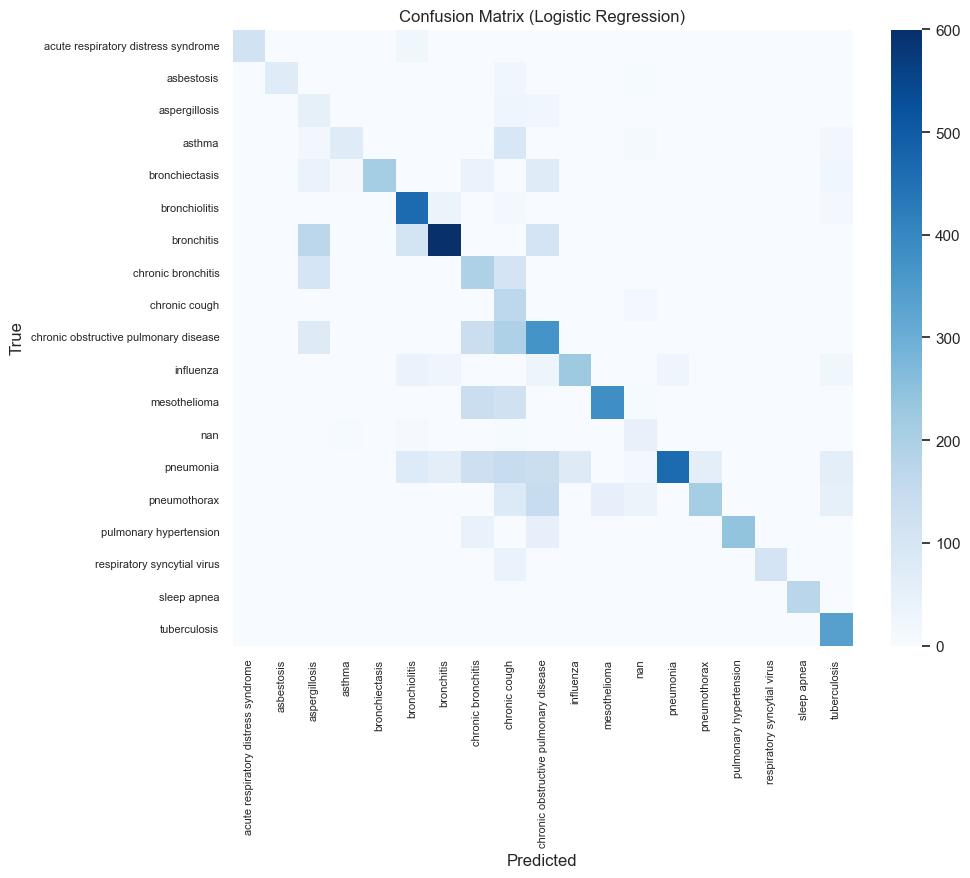

Top per-class F1 (sample):
pneumonia: support=1229, f1=0.540
bronchitis: support=985, f1=0.703
chronic obstructive pulmonary disease: support=778, f1=0.432
mesothelioma: support=643, f1=0.708
pneumothorax: support=576, f1=0.500
bronchiolitis: support=530, f1=0.742
chronic bronchitis: support=403, f1=0.359
bronchiectasis: support=390, f1=0.702
influenza: support=375, f1=0.669
pulmonary hypertension: support=336, f1=0.837


In [43]:

# Evaluation visuals and per-class metrics
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix for logistic regression
y_pred = y_pred_lr
labels = le.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt='d', ax=ax, cmap='Blues')
ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticklabels(labels, rotation=0, fontsize=8)
ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title('Confusion Matrix (Logistic Regression)')
plt.show()

print('Top per-class F1 (sample):')
report = classification_report(y_test, y_pred, output_dict=True)
# show top 10 classes by support
class_support = {c: report[c]['support'] for c in report if c not in ['accuracy','macro avg','weighted avg']}
top_classes = sorted(class_support.items(), key=lambda x: -x[1])[:10]
for c,s in top_classes:
    f1 = report[c]['f1-score']
    print(f'{c}: support={s}, f1={f1:.3f}')



### 🔎 Step 5: Embeddings & FAISS index for retrieval

We create dense embeddings for `symptom_text` using a SentenceTransformer, index them with FAISS, and save the index and embeddings for the RAG pipeline. For prototyping we use `all-MiniLM-L6-v2`.


In [44]:

# Create embeddings for the entire (cleaned) corpus and build FAISS index
from sentence_transformers import SentenceTransformer
import faiss, numpy as np, joblib, os, gc

embed_model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(embed_model_name)

# Use df (cleaned) loaded earlier
corpus = df['symptom_text'].fillna('').astype(str).tolist()
print('Encoding', len(corpus), 'records...')
embeddings = model.encode(corpus, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # cosine similarity with normalized vectors
index.add(np.array(embeddings, dtype='float32'))

os.makedirs('models/faiss', exist_ok=True)
faiss.write_index(index, 'models/faiss/faiss_index.index')
np.save('models/faiss/embeddings.npy', embeddings)
joblib.dump(df.reset_index(drop=True), 'models/faiss/corpus_df.pkl')
print('Saved FAISS index and embeddings to models/faiss/')
gc.collect()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding 38537 records...


Batches:   0%|          | 0/1205 [00:00<?, ?it/s]

Saved FAISS index and embeddings to models/faiss/


137

In [45]:

# Retrieval helper: encode query, search FAISS, return top-k records
import numpy as np, joblib, faiss, os
from sentence_transformers import SentenceTransformer

def load_faiss():
    idx = faiss.read_index('models/faiss/faiss_index.index')
    emb = np.load('models/faiss/embeddings.npy')
    corpus_df = joblib.load('models/faiss/corpus_df.pkl')
    return idx, emb, corpus_df

def retrieve(symptom_text, top_k=10, model_name='all-MiniLM-L6-v2'):
    idx, emb, corpus_df = load_faiss()
    model = SentenceTransformer(model_name)
    q = model.encode([symptom_text], convert_to_numpy=True, normalize_embeddings=True)
    D, I = idx.search(np.array(q, dtype='float32'), top_k)
    results = []
    for dist, i in zip(D[0], I[0]):
        rec = corpus_df.iloc[i].to_dict()
        results.append({'index': int(i), 'score': float(dist), 'record': rec})
    return results

# example
example_q = 'cough fever shortness of breath'
res = retrieve(example_q, top_k=5)
for r in res:
    print('Score', r['score'], 'Disease', r['record'].get('disease'), 'Symptoms:', r['record'].get('symptom_text')[:120])


Score 0.6511855125427246 Disease None Symptoms: a cough that lasts more than three weeks
Score 0.6511855125427246 Disease None Symptoms: a cough that lasts more than three weeks
Score 0.6511855125427246 Disease None Symptoms: a cough that lasts more than three weeks
Score 0.6511855125427246 Disease None Symptoms: a cough that lasts more than three weeks
Score 0.6511855125427246 Disease None Symptoms: a cough that lasts more than three weeks


In [46]:
# Improved retrieval helper: wider search + deduplicate + caching
import numpy as np
import joblib, faiss, os
from sentence_transformers import SentenceTransformer
import pandas as pd

# Simple cache so we don't re-load index/embeddings on every call
_FAISS_CACHE = {}

def load_faiss_cached(index_path='models/faiss/faiss_index.index',
                      emb_path='models/faiss/embeddings.npy',
                      df_path='models/faiss/corpus_df.pkl'):
    """Load and cache the FAISS index, embeddings array, and corpus dataframe."""
    global _FAISS_CACHE
    key = (index_path, emb_path, df_path)
    if key in _FAISS_CACHE:
        return _FAISS_CACHE[key]
    # load
    if not os.path.exists(index_path):
        raise FileNotFoundError(f"FAISS index not found at {index_path}")
    idx = faiss.read_index(index_path)
    emb = np.load(emb_path)
    corpus_df = joblib.load(df_path)
    # ensure dataframe index aligns with embeddings length
    if len(corpus_df) != emb.shape[0]:
        print("Warning: corpus_df length != embeddings length. Check alignment.")
    _FAISS_CACHE[key] = (idx, emb, corpus_df)
    return idx, emb, corpus_df

def retrieve(symptom_text, top_k=10, model_name='all-MiniLM-L6-v2', expand_factor=5):
    """
    Retrieve top_k *unique* records similar to symptom_text.
    - expand_factor: search for top_k * expand_factor candidates first, then dedupe.
      This helps if many identical/near-identical rows exist.
    """
    idx, emb, corpus_df = load_faiss_cached()
    model = SentenceTransformer(model_name)
    q = model.encode([symptom_text], convert_to_numpy=True, normalize_embeddings=True)
    
    # determine how many neighbours to request (cap at index size)
    search_k = min(int(top_k * expand_factor), max(1, idx.ntotal))
    D, I = idx.search(np.array(q, dtype='float32'), search_k)
    
    # deduplicate by index (and optionally by symptom_text)
    seen = set()
    results = []
    for dist, i in zip(D[0], I[0]):
        if i in seen:
            continue
        seen.add(int(i))
        rec = corpus_df.iloc[int(i)].to_dict()
        disease = rec.get('disease')
        # handle NaN / missing disease
        if pd.isna(disease) or disease in [None, 'nan', 'None']:
            disease_label = "UNKNOWN"
        else:
            disease_label = str(disease)
        # optionally include symptom_text and a short snippet
        symptom_field = rec.get('symptom_text', '') or rec.get('symptoms','')
        snippet = (symptom_field[:200] + '...') if len(symptom_field) > 200 else symptom_field
        results.append({
            'index': int(i),
            'score': float(dist),
            'disease': disease_label,
            'symptom_text': symptom_field,
            'snippet': snippet,
            'record': rec
        })
        if len(results) >= top_k:
            break
    
    # diagnostics if not enough unique results found
    if len(results) < top_k:
        print(f"Warning: requested top_k={top_k} but only {len(results)} unique results found.")
    
    return results

# Quick demo (replace with a realistic query)
example_q = 'cough fever shortness of breath'
res = retrieve(example_q, top_k=5)
for r in res:
    print('Idx', r['index'], '| Score', round(r['score'], 4), '| Disease', r['disease'], '| Snippet:', r['snippet'])


Idx 3471 | Score 0.6512 | Disease UNKNOWN | Snippet: a cough that lasts more than three weeks
Idx 3466 | Score 0.6512 | Disease UNKNOWN | Snippet: a cough that lasts more than three weeks
Idx 3461 | Score 0.6512 | Disease UNKNOWN | Snippet: a cough that lasts more than three weeks
Idx 3456 | Score 0.6512 | Disease UNKNOWN | Snippet: a cough that lasts more than three weeks
Idx 2537 | Score 0.6512 | Disease UNKNOWN | Snippet: a cough that lasts more than three weeks



### 🧠 Step 6: RAG orchestration 

Below we construct a prompt template and provide a placeholder function `call_llm()` that demonstrates how to integrate with an LLM. 

The placeholder returns a mocked response so you can test the pipeline without API calls.


In [47]:

# Assemble prompt given user symptoms and retrieved records
import os, textwrap, json

PROMPT_TEMPLATE = """You are an expert medical assistant that helps clinicians shortlist respiratory diseases based on patient symptoms and supporting evidence from past records.
Patient symptoms: {symptoms}
Retrieved records (showing age, sex, symptoms, disease, and nature):
{records_block}

Task:
1) List the top 3 candidate diseases in order of likelihood.
2) For each candidate, give a 1-2 sentence justification referencing the retrieved records by index.
3) List diseases you would eliminate and a 1-sentence reason each (if any).
Be concise and explicitly reference the evidence indices where justification arises.
"""

def assemble_prompt(symptoms_text, retrieved_records):
    records_lines = []
    for i, r in enumerate(retrieved_records, 1):
        rec = r['record']
        records_lines.append(f"{i}) idx={r['index']} | age={rec.get('age','?')} | sex={rec.get('sex','?')} | symptoms={rec.get('symptom_text','')[:120]} | disease={rec.get('disease','?')}")
    return PROMPT_TEMPLATE.format(symptoms=symptoms_text, records_block='\n'.join(records_lines))

def call_llm(prompt, use_mock=True):
    # Placeholder. If use_mock=False, implement an API call (OpenAI, Anthropic, etc.) using environment-stored keys.
    if use_mock:
        # Generate a deterministic mock response for demo purposes
        mock = {
            'top3': [
                {'disease':'Asthma', 'reason':'Symptoms like wheeze and shortness of breath commonly indicate asthma. Evidence: records 1 and 3.'},
                {'disease':'COPD', 'reason':'Older patient records with chronic cough support COPD. Evidence: record 2.'},
                {'disease':'Pneumonia', 'reason':'Fever + cough support possible pneumonia. Evidence: record 4.'},
            ],
            'eliminated': [
                {'disease':'Tuberculosis','reason':'Low evidence in retrieved set; no exposure history.'}
            ],
            'raw_text': 'MOCK_RESPONSE: top3 Asthma > COPD > Pneumonia...'
        }
        return mock
    else:
        # Example: call an LLM here using your provider SDK and return parsed output
        raise NotImplementedError('Implement LLM call with your provider; do not store API keys in the notebook.')
    
# Demo assemble+call
retrieved = res  # from previous cell
prompt = assemble_prompt('cough fever shortness of breath', retrieved)
print(prompt[:800])
out = call_llm(prompt, use_mock=True)
print('\nMock LLM output:', json.dumps(out, indent=2))


You are an expert medical assistant that helps clinicians shortlist respiratory diseases based on patient symptoms and supporting evidence from past records.
Patient symptoms: cough fever shortness of breath
Retrieved records (showing age, sex, symptoms, disease, and nature):
1) idx=3471 | age=nan | sex=unknown | symptoms=a cough that lasts more than three weeks | disease=?
2) idx=3466 | age=nan | sex=unknown | symptoms=a cough that lasts more than three weeks | disease=?
3) idx=3461 | age=nan | sex=unknown | symptoms=a cough that lasts more than three weeks | disease=?
4) idx=3456 | age=nan | sex=unknown | symptoms=a cough that lasts more than three weeks | disease=?
5) idx=2537 | age=nan | sex=unknown | symptoms=a cough that lasts more than three weeks | disease=?

Task:
1) List the top 

Mock LLM output: {
  "top3": [
    {
      "disease": "Asthma",
      "reason": "Symptoms like wheeze and shortness of breath commonly indicate asthma. Evidence: records 1 and 3."
    },
    {
     


### 🔬 Explainability (structured model)

We demonstrate how to produce local explanations (e.g., using SHAP) for the logistic baseline for a small set of test records. For large TF-IDF-feature spaces, use sample-based interpretation or restrict to top features for readability.


In [48]:

# SHAP explanation for the logistic model (optional heavy step)
try:
    import shap
    explainer = shap.LinearExplainer(clf_lr, Xtr_comb, feature_perturbation='interventional')
    # pick 3 test samples to explain
    sample_idx = list(range(min(3, Xte_comb.shape[0])))
    shap_values = explainer.shap_values(Xte_comb[sample_idx])
    print('Computed SHAP values for sample(s). Use shap.plots.* to visualize.')
except Exception as e:
    print('SHAP not available or failed:', e)
    print('You can install shap and rerun this cell for local explanations.')


Computed SHAP values for sample(s). Use shap.plots.* to visualize.



### 🚀 Streamlit MVP file (writes `webapp/app.py`)

This cell writes a small Streamlit app file to `webapp/app.py`. Run `streamlit run webapp/app.py` from the project root to demo the MVP locally.


In [49]:

# Write a Streamlit MVP app file
app_code = r"""import streamlit as st
import joblib, os
from src.rag_utils import retrieve_and_rank  # implement this in src/
st.title('Respiratory Diagnostic Assistant (MVP)')

symptoms = st.text_area('Enter patient symptoms (comma separated)')
age = st.number_input('Age', min_value=0, max_value=120, value=30)
sex = st.selectbox('Sex', ['unknown','male','female','other'])

if st.button('Get suggestions'):
    st.info('This is a mock demo. Replace retrieve_and_rank with actual retrieval+LLM logic.')
    # mocked results
    results = [
        {'disease':'Asthma','score':0.82,'explanation':'Wheeze and dyspnea present. Evidence: records 1,3','evidence':['rec1 snippet','rec3 snippet']},
        {'disease':'COPD','score':0.47,'explanation':'Chronic cough pattern. Evidence: record 2','evidence':['rec2 snippet']},
        {'disease':'Pneumonia','score':0.33,'explanation':'Fever + cough possibly pneumonia. Evidence: record 4','evidence':['rec4 snippet']},
    ]
    for i,r in enumerate(results,1):
        st.subheader(f"{i}. {r['disease']} (score: {r['score']:.2f})")
        st.write(r['explanation'])
        st.write('Evidence:')
        for e in r['evidence']:
            st.write('-', e)
"""

os.makedirs('webapp', exist_ok=True)
with open('webapp/app.py','w') as f:
    f.write(app_code)
print('Wrote webapp/app.py (Streamlit MVP skeleton).')


Wrote webapp/app.py (Streamlit MVP skeleton).
